<a href="https://colab.research.google.com/github/maxmatical/TMLS_NLP/blob/master/twitter_sentiment_improvements_fwd_and_ensemble_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
!pip install git+https://github.com/fastai/fastai.git

In [2]:
# Set up environment and download course-v3
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from fastai import *
from fastai.text import *
from fastai.utils.show_install import *
from fastai.callbacks import *
show_install()



```text
=== Software === 
python        : 3.6.8
fastai        : 1.0.60.dev0
fastprogress  : 0.1.21
torch         : 1.3.0+cu100
nvidia driver : 418.67
torch cuda    : 10.0.130 / is available
torch cudnn   : 7603 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 11441MB | Tesla K80

=== Environment === 
platform      : Linux-4.14.137+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Thu Aug 8 02:47:02 PDT 2019
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:
pip install distro
Once installe

# EDA

In [0]:
df = pd.read_csv('testset1.csv')

In [9]:
print(len(df))

df.head(5)

5585


,id,name,date,text,location,sentiment
0,1.130000e+18,Evolutionomics,Sun May 19 23:57:10 +0000 2019,By combining short positions on #Gold $GOLD $G...,NaN,bearish
1,1.130000e+18,macrohedged,Sun May 19 23:55:02 +0000 2019,Here are the #Volatility levels for the majors...,England,unrelated
2,1.130000e+18,Evolutionomics,Sun May 19 23:54:06 +0000 2019,We have little insight into what will happen t...,NaN,neutral
3,1.130000e+18,Evolutionomics,Sun May 19 23:50:59 +0000 2019,"This brings us to #Gold miners. As a group, $G...",NaN,neutral
4,1.130000e+18,macrohedged,Sun May 19 23:50:04 +0000 2019,"Good morning Asia, here are the benchmark futu...",England,unrelated


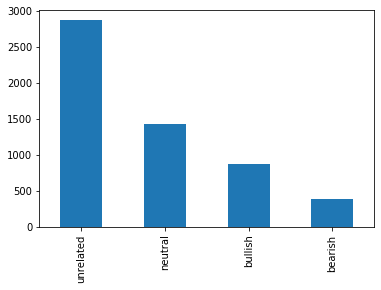

In [10]:
df['sentiment'].value_counts().plot(kind='bar')

Unrelated and neutral sentiments dominate the data currently (although this might not be the case in the future with the full dataset). It might be better to use a stratified sampling technique for classification

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
sss.get_n_splits(df['text'], df['sentiment'])

print(sss)



StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.2,
            train_size=None)


In [12]:
train_idx, val_idx = next(sss.split(df['text'], df['sentiment']))

print(len(train_idx), len(val_idx))

4468 1117


Verifying that the stratified split preseves the distribution of the labels

In [0]:
df_train = df.iloc[train_idx, :]
df_val = df.iloc[val_idx, :]

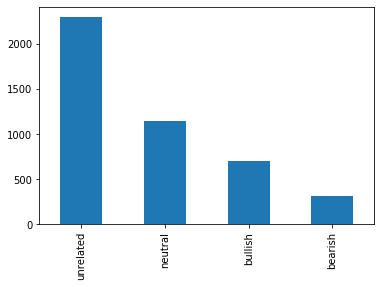

In [14]:
df_train['sentiment'].value_counts().plot(kind='bar')

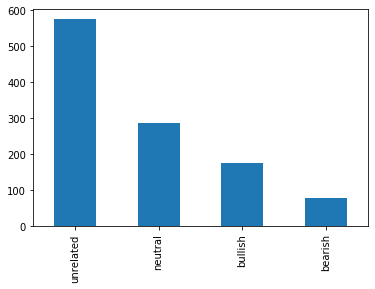

In [15]:
df_val['sentiment'].value_counts().plot(kind='bar')

Looks like the distribution of the labels in train and val are the same, so we can start modelling now

# Handling Imbalanced Data: Oversampling

In [0]:
df_class_bull = df_train[df_train['sentiment'] == 'bullish']
df_class_bear = df_train[df_train['sentiment'] == 'bearish']
df_class_neutral = df_train[df_train['sentiment'] == 'neutral']
df_class_unrelated = df_train[df_train['sentiment'] == 'unrelated']



In [17]:
print(len(df_class_unrelated))

2298


Want to oversample so that every class has 2298 counts

In [0]:
df_class_bull_over = df_class_bull.sample(len(df_class_unrelated), replace = True)
df_class_bear_over = df_class_bear.sample(len(df_class_unrelated), replace = True)
df_class_neutral_over = df_class_neutral.sample(len(df_class_unrelated), replace = True)


df_train_oversampled = pd.concat([df_class_bull_over, df_class_bear_over, df_class_neutral_over, df_class_unrelated], axis = 0)



Look at distribution of the labels in the oversampled data

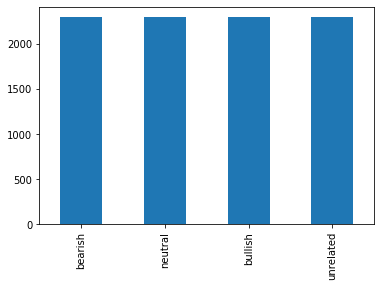

In [19]:
df_train_oversampled['sentiment'].value_counts().plot(kind='bar')

# Setting up data

In [0]:
PATH = '/content/'


In [21]:
ls{PATH}

data@  models@  testset1.csv


In [0]:
bs = 128

In [0]:
# data_lm = TextLMDataBunch.from_df(path = PATH, 
#                                   train_df = df_train_oversampled,
#                                   valid_df = df_val,
#                                   text_cols='text',
#                                   min_freq = 3,
#                                   bs = bs) 

"""
Original databunch, no need for oversampling since were not doing classification
so we don't need to worry about class imbalance

"""
data_lm = TextLMDataBunch.from_csv(path = PATH, 
                                   csv_name = 'testset1.csv', 
                                   text_cols='text',
                                   valid_pct = 0.1,
                                   min_freq = 3,
                                   bs = bs) 


data_lm.save('data_lm_fwd')


In [0]:

data_clas = TextClasDataBunch.from_df(path = PATH,
                                        train_df = df_train_oversampled,
                                        valid_df = df_val,
                                        vocab = data_lm.train_ds.vocab,
                                        text_cols = 'text',
                                        label_cols = 'sentiment',
                                        bs = bs)


data_clas.save('data_clas_fwd')


# Training forward model


## Language Model



In [0]:
data_lm = load_data(PATH, 'data_lm_fwd', bs = bs)

Look at what the preprocessed text looks like

In [26]:
data_lm.show_batch()

idx,text
0,"sentiment , then we continue down . $ gold to 1320 . https : / / t.co / tioikccioi xxbos xxmaj long $ gold $ gc https : / / t.co / xxunk xxbos xxmaj how # hedgefunds are positioned in futures . $ xxup tnx $ xxup tyx $ xxup spx $ xxup rut $ xxup ndx $ xxup vix $ xxup gld $ xxup eur $ xxup usd"
1,") ( xxup nyse : $ xxup trx ) https : / / t.co / xxunk xxbos $ xxup gld rose by xxunk % . xxmaj currently xxunk at xxunk . https : / / t.co / xxunk xxbos xxmaj gold xxmaj miners could start a new rally from this price point , says xxmaj joe xxmaj friday . xxmaj one of the most important support tests in years is"
2,/ / t.co / 5cmhudsbq6 xxbos xxmaj gold | $ xxup gold | $ xxup xau $ xxup usd \n \n xxup gold xxmaj long \n \n xxmaj long or short it on xxup wcx : https : / / t.co / gfnsxoenz8 https : / / t.co / xxunk xxbos xxmaj it was a pleasure speaking with @lukegromen \n recently . xxmaj interesting his pointing out
3,"is $ 1255 - 60 - this is the intersection of the 200dma and the uptrendline from the xxmaj august low https : / / t.co / ayikquvrch xxbos * xxmaj broken xxmaj record xxmaj alert * xxmaj junior xxmaj miners weekly still "" bullish "" longer - term and will soon break higher . \n $ xxup gdxj $ xxup gld # xxmaj gold # goldminers # preciousmetals"
4,"like xxmaj gold should be safe now from more downside \n \n # xxmaj metals $ xxup gc # xxup gc # xxup gld $ xxup gld https : / / t.co / 43das3yitl xxbos i still think xxunk is a xxunk target for $ xxmaj gold by year 's end . xxbos xxmaj read our xxup free xxmaj online xxmaj daily xxmaj newspaper , catch up with latest"


In [0]:
"""
Default AdamW
"""


learn = language_model_learner(data_lm, 
                               arch=AWD_LSTM, 
                               loss_func = FlattenedLoss(LabelSmoothingCrossEntropy, axis=-1),
                               drop_mult=1.).to_fp16()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-01
Min loss divided by 10: 5.25E-02


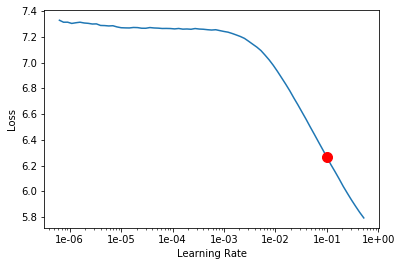

In [28]:
learn.lr_find()
learn.recorder.plot(suggestion = True, skip_end=15)

fitting learner

fit_fc for new optimizers

fit_one_cycle for adamw/lamb/LookaheadAdam

epoch,train_loss,valid_loss,accuracy,time
0,4.591938,3.093186,0.591674,00:29
1,3.534665,2.543967,0.723705,00:29
2,3.174967,2.528317,0.740491,00:29
3,2.985215,2.424199,0.762076,00:29
4,2.886685,2.400230,0.764130,00:29
5,2.774359,2.339348,0.778616,00:29
6,2.685539,2.289477,0.787411,00:29
7,2.598691,2.250554,0.793995,00:29
8,2.527482,2.234207,0.797723,00:29
9,2.473707,2.230591,0.798951,00:29


Better model found at epoch 0 with accuracy value: 0.5916740894317627.
Better model found at epoch 1 with accuracy value: 0.7237054109573364.
Better model found at epoch 2 with accuracy value: 0.7404910922050476.
Better model found at epoch 3 with accuracy value: 0.7620758414268494.
Better model found at epoch 4 with accuracy value: 0.7641295194625854.
Better model found at epoch 5 with accuracy value: 0.7786160707473755.
Better model found at epoch 6 with accuracy value: 0.7874106764793396.
Better model found at epoch 7 with accuracy value: 0.7939954996109009.
Better model found at epoch 8 with accuracy value: 0.7977231740951538.
Better model found at epoch 9 with accuracy value: 0.7989508509635925.


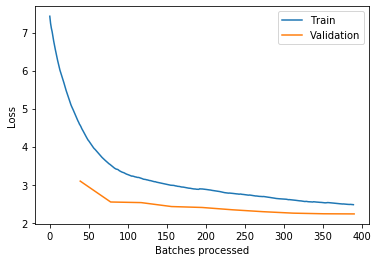

In [29]:
lr_init = 0.1
lr = lr_init


"""
1 cycle policy

"""

learn.fit_one_cycle(10,
                   lr,
                   moms=(0.8,0.7),
                   callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', 
                                                             name='lm_stage1')])


"""
1 cycle policy without clipping momentum

"""

# learn.fit_one_cycle(5,
#                    lr,
#                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', 
#                                                              name='lm_stage1'),])

learn.recorder.plot_losses()

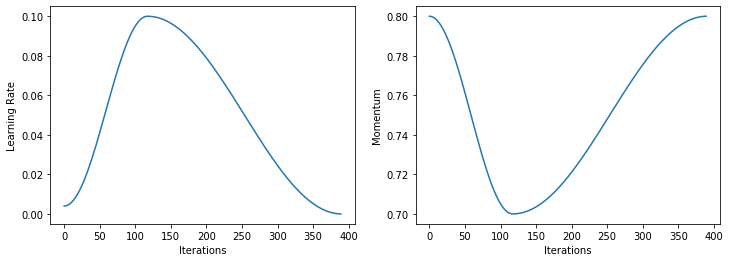

In [30]:
learn.recorder.plot_lr(show_moms=True)

In [0]:
learn.load('lm_stage1');
learn.unfreeze()


epoch,train_loss,valid_loss,accuracy,time
0,2.382976,2.176516,0.802388,00:40
1,2.318691,2.110914,0.811629,00:40
2,2.256619,2.086051,0.817679,00:40
3,2.160916,2.017246,0.830692,00:40
4,2.075545,1.981940,0.836630,00:40
5,2.024832,1.955146,0.841473,00:40
6,1.974775,1.946366,0.844955,00:40
7,1.937437,1.941292,0.846696,00:40
8,1.903300,1.935013,0.848304,00:40
9,1.886495,1.931892,0.848973,00:40


Better model found at epoch 0 with accuracy value: 0.8023883700370789.
Better model found at epoch 1 with accuracy value: 0.8116294741630554.
Better model found at epoch 2 with accuracy value: 0.8176785707473755.
Better model found at epoch 3 with accuracy value: 0.8306919932365417.
Better model found at epoch 4 with accuracy value: 0.8366295099258423.
Better model found at epoch 5 with accuracy value: 0.8414732217788696.
Better model found at epoch 6 with accuracy value: 0.844955325126648.
Better model found at epoch 7 with accuracy value: 0.8466964960098267.
Better model found at epoch 8 with accuracy value: 0.8483036160469055.
Better model found at epoch 9 with accuracy value: 0.848973274230957.


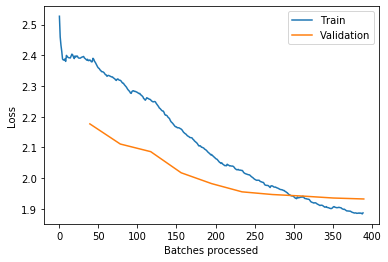

In [32]:
# train with smaller LR in last layer
lr =lr_init/10

learn.fit_one_cycle(10,
                   slice(lr/(2.6**4),lr),
                   moms=(0.8,0.7),
                   callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', 
                   name='lm_stage2')])


learn.recorder.plot_losses()



Testing the performance of our language model

In [0]:
learn.load('lm_stage2');

In [34]:
learn.predict('$GLD is ', 20, temperature=0.25, min_p=0.001)

"$GLD is  now starting to take moves since 2018 . i 'll show that it might exceed to $ usdu $ yinn"

Save encoder for classification

In [0]:
learn.save_encoder('lm_encoder')

## Classifier

In [0]:
data_clas = load_data(PATH, 'data_clas_fwd', bs = bs)

Look at the data

In [37]:
data_clas.show_batch()

text,target
"xxbos xxmaj we d ( 5 / 29 / 19 ) trading range < 15 % ( xxmaj min $ 5 , xxmaj vol > 750 k , xxmaj opt xxmaj vol in any strike > 500 ) : $ xxup xxunk $ xxup bb $ xxup xxunk $ xxup xxunk $ xxup xxunk $ xxup stay $ xxup xxunk $ xxup xxunk $ xxup xxunk $ xxup xxunk $",unrelated
xxbos * * * xxmaj silver and xxmaj gold are on xxunk today xxrep 4 * \n \n $ xxup xlf $ xxup bac $ xxup eem $ xxup gdx $ xxup uso $ xxup efa $ xxup spy $ xxup gld $ xxup slv $ xxup ftse $ xxup dax $ xxup spy $ xxup gld $ xxup slv $ xxup ftse $ xxup btc.x $ xxup xxunk,bullish
xxbos xxmaj xxunk of the year xxunk goes to xxunk . \n $ xxup spy $ xxup iwm $ xxup qqq $ xxup xli $ xxup xxunk $ xxup mmm $ xxup cat $ xxup ba $ xxup tlt $ xxup gld $ xxup cl_f $ xxup xle $ xxup xom $ xxup cvx $ xxup xlf $ xxup jpm $ xxup gs $ xxup xrt $ xxup xxunk,unrelated
xxbos ' # xxmaj oil xxmaj xxunk xxmaj xxunk as xxmaj market xxmaj falls . \n \n xxmaj but # xxmaj safehaven xxmaj gold < xxmaj is up today nicely . \n \n $ xxup xlf $ xxup bac $ xxup eem $ xxup gdx $ xxup uso $ xxup efa $ xxup spy $ xxup gld $ xxup slv $ xxup ftse $ xxup dax $ xxup,bullish
xxbos # estate asset watch - most active stocks xxmaj friday - $ xxup amd $ xxup bac $ t $ f xxup xxunk $ xxup gps $ xxup jci $ xxup eca $ xxup vale $ xxup snap $ xxup teva $ xxup baba $ s $ xxup vz $ xxup siri $ xxup rig $ xxup uber $ xxup ntnx $ xxup aapl $ xxup xxunk $ xxup,unrelated


Making sure the vocab is the same between the language model and classifier

In [0]:
data_clas.vocab.itos = data_lm.vocab.itos

Trying different opt_funcs

- default
- partial(optim.Adam, eps = 0.1)
- partial(optim.SGD)
- Radam
- ranger

Observations:
adam with eps 0.1/0.01 and SGD with nesterov momentum seems to take much longer to train

In [0]:
# learn = text_classifier_learner(data_clas, 
#                                 arch = AWD_LSTM,
#                                 loss_func = FlattenedLoss(LabelSmoothingCrossEntropy, axis=-1),
#                                 drop_mult=0.3,
#                                 metrics = [accuracy],
#                                 opt_func = optar,
#                                 bn_wd = False,
#                                 true_wd = True,).to_fp16

"""
learner with default adamw

"""
learn = text_classifier_learner(data_clas, 
                                arch = AWD_LSTM,
                                loss_func = FlattenedLoss(LabelSmoothingCrossEntropy, axis=-1),
                                drop_mult=0.1, # try lower drop mult (0.1-0.3)
                                metrics = [accuracy]).to_fp16()

learn.load_encoder('lm_encoder')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.74E-03
Min loss divided by 10: 2.51E-02


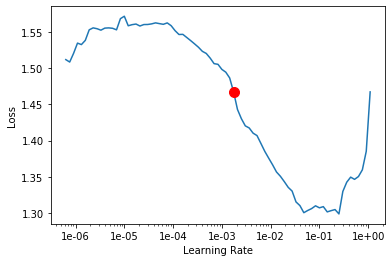

In [40]:
learn.lr_find()
learn.recorder.plot(suggestion = True)

epoch,train_loss,valid_loss,accuracy,time
0,1.156598,0.859849,0.732319,00:26
1,0.964504,0.796207,0.774396,00:27
2,0.860215,0.792575,0.802149,00:27
3,0.795379,0.788059,0.795882,00:27
4,0.754798,0.827976,0.796777,00:27
5,0.752020,0.793733,0.820949,00:23
6,0.691708,0.790778,0.813787,00:27
7,0.680143,0.804619,0.821844,00:25
8,0.628267,0.737166,0.843330,00:25
9,0.575219,0.750447,0.837959,00:25


Better model found at epoch 0 with accuracy value: 0.7323186993598938.
Better model found at epoch 1 with accuracy value: 0.7743957042694092.
Better model found at epoch 2 with accuracy value: 0.8021486401557922.
Better model found at epoch 5 with accuracy value: 0.8209489583969116.
Better model found at epoch 7 with accuracy value: 0.821844220161438.
Better model found at epoch 8 with accuracy value: 0.8433303236961365.


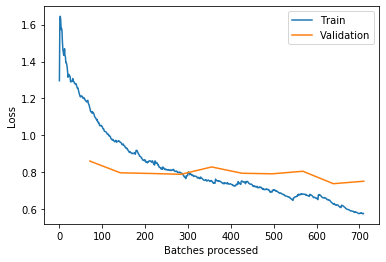

In [41]:
lr_init = 2e-2
lr = lr_init
# learn.fit_one_cycle(10, 
#                    lr, 
#                    moms=(0.8,0.7),
#                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', 
#                                                              name='classifier_stage1')])
learn.fit_fc(10,
             lr,
             moms=(0.8,0.7),
             callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', 
             name='classifier_stage1')])


learn.recorder.plot_losses()

Gradual unfreezing



In [0]:
learn.load('classifier_stage1');
learn.freeze_to(-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.558920,0.790173,0.835273,00:27
1,0.641712,0.774762,0.829902,00:26
2,0.635175,0.745927,0.836168,00:24
3,0.577434,0.742832,0.846016,00:29
4,0.549106,0.725227,0.845121,00:26


Better model found at epoch 0 with accuracy value: 0.835273027420044.
Better model found at epoch 2 with accuracy value: 0.8361682891845703.
Better model found at epoch 3 with accuracy value: 0.8460161089897156.


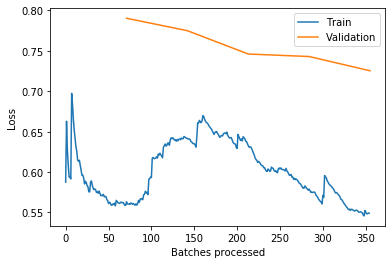

In [43]:
lr = lr_init

learn.fit_one_cycle(5,
                   slice(lr/(2.6**4),lr), 
                   moms=(0.8,0.7),
                   callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', 
                                                             name='classifier_stage2')])

learn.recorder.plot_losses()

In [0]:
learn.load('classifier_stage2');
learn.freeze_to(-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.602572,0.847757,0.829902,00:36
1,0.716961,0.785842,0.830797,00:30
2,0.598576,0.726023,0.843330,00:30
3,0.533608,0.692885,0.856759,00:30
4,0.506438,0.707194,0.844226,00:34


Better model found at epoch 0 with accuracy value: 0.8299015164375305.
Better model found at epoch 1 with accuracy value: 0.8307967782020569.
Better model found at epoch 2 with accuracy value: 0.8433303236961365.
Better model found at epoch 3 with accuracy value: 0.8567591905593872.


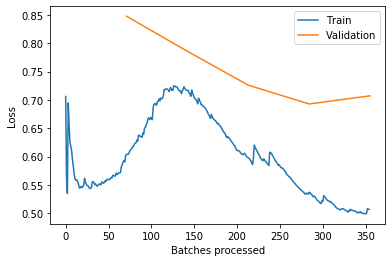

In [45]:
# train with smaller LR in last layer (/2)
lr = lr_init/2

learn.fit_one_cycle(5,
                   slice(lr/(2.6**4),lr), 
                   moms=(0.8,0.7),
                   callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', 
                                                             name='classifier_stage3')])

learn.recorder.plot_losses()

In [0]:
learn.load('classifier_stage3');
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time
0,0.481891,0.691355,0.851388,01:11
1,0.497633,0.697872,0.847807,01:10
2,0.486163,0.736457,0.854073,01:18
3,0.487316,0.698361,0.856759,01:10
4,0.479933,0.721061,0.849597,01:08
5,0.462450,0.673168,0.870188,01:15
6,0.464407,0.694478,0.854969,01:06
7,0.455098,0.678900,0.863026,01:21
8,0.444644,0.672356,0.863921,01:20
9,0.454045,0.669108,0.862131,01:07


Better model found at epoch 0 with accuracy value: 0.851387619972229.
Better model found at epoch 2 with accuracy value: 0.8540734052658081.
Better model found at epoch 3 with accuracy value: 0.8567591905593872.
Better model found at epoch 5 with accuracy value: 0.8701879978179932.


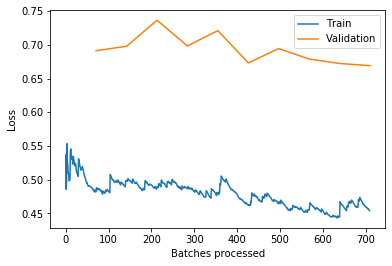

In [47]:
# train with smaller LR in last layer /10
lr = lr_init/10

learn.fit_one_cycle(10,
                   slice(lr/(2.6**4),lr), 
                   moms=(0.8,0.7),
                   callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', 
                                                             name='classifier_final')])

learn.recorder.plot_losses()

Optional additional training

In [0]:
# learn.load('radam_classifier_final');


# learn.fit_one_cycle(10,
#                    slice(lr/(2.6**4),lr), 
#                    moms=(0.8,0.7),
#                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', 
#                                                              name='radam_classifier_final_2')])

# learn.recorder.plot_losses()

Additional training doesn't seem to benefit 

final accuracy approximately 0.86571

Exporting model

In [0]:
learn.load('classifier_final');

learn.export()

# Ensembling forward and backwards model

Forward model

In [0]:
learn_c = text_classifier_learner(data_clas, 
                                  AWD_LSTM,
                                  metrics=[accuracy, error_rate])#.to_fp16()
                                  
learn_c.load('classifier_final', purge=False);

Backwards model

In [0]:
data_clas_bwd = load_data(PATH, 
                          'data_clas_bkwd', 
                          bs=bs, 
                          num_workers=1, 
                          backwards=True)

learn_c_bwd = text_classifier_learner(data_clas_bwd, 
                                      AWD_LSTM,
                                      metrics=[accuracy, error_rate])#.to_fp32()

learn_c_bwd.load('classifier_bkwd_final', purge=False);